<a href="https://colab.research.google.com/github/RFA863/VAE_models_for_reconstruct_dataset/blob/main/VAE_MovieLens100K_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
from scipy import sparse
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
import warnings
import requests
import zipfile
from io import BytesIO

# Mengabaikan UserWarning yang tidak kritikal dari Keras
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
# =============================================================================
# 1. PERSIAPAN DATA DAN LINGKUNGAN
# =============================================================================
print("TensorFlow version:", tf.__version__)

# Direktori output
output_dir = './vae_output_movielens/'
os.makedirs(output_dir, exist_ok=True)
print(f"Direktori output akan berada di: {output_dir}")

# --- Download dan Ekstrak Dataset MovieLens 100K ---
print("Mengunduh dataset MovieLens 100K...")
url = "http://files.grouplens.org/datasets/movielens/ml-100k.zip"
response = requests.get(url)
with zipfile.ZipFile(BytesIO(response.content)) as z:
    z.extractall(".")
print("Dataset berhasil diunduh dan diekstrak.")

data_path = 'ml-100k/u.data'
item_data_path = 'ml-100k/u.item'

# Memuat dataset
try:
    # Memuat data rating
    raw_data_rating = pd.read_csv(data_path, sep='\t', header=None, names=['user_id', 'item_id', 'rating', 'timestamp'])
    # Memuat data item (film)
    movies_df = pd.read_csv(item_data_path, sep='|', header=None, encoding='latin-1', usecols=[0, 1], names=['item_id', 'title'])
    print("Dataset MovieLens 100K berhasil dimuat.")
except FileNotFoundError:
    print(f"FATAL ERROR: Pastikan file '{data_path}' dan '{item_data_path}' ada di direktori kerja.")
    exit()

# Pra-pemrosesan data dasar
# Kita hanya memerlukan interaksi, jadi kita ambil user_id dan item_id
# Kita anggap setiap rating sebagai interaksi implisit
raw_df = raw_data_rating[['user_id','item_id']].copy()

# MovieLens ID sudah dimulai dari 1, jadi kita kurangi 1 agar dimulai dari 0
raw_df['user_id'] -= 1
raw_df['item_id'] -= 1

# Fungsi untuk filtering data
def get_count(df, col): return df.groupby(col).size()
def filter_triplets(df, min_user_count=5, min_item_count=0):
    if min_user_count > 0:
        user_counts = get_count(df, 'user_id')
        df = df[df['user_id'].isin(user_counts.index[user_counts >= min_user_count])]
    if min_item_count > 0:
        item_counts = get_count(df, 'item_id')
        df = df[df['item_id'].isin(item_counts.index[item_counts >= min_item_count])]
    return df, get_count(df, 'user_id'), get_count(df, 'item_id')

# Melakukan filtering (opsional, tapi disarankan)
# Untuk MovieLens, kita bisa mulai dengan min_user_count=5
data, user_activity, item_popularity = filter_triplets(raw_df, min_user_count=5)

# Remapping User ID
unique_user_ids = user_activity.index
n_users = len(unique_user_ids)
user_map = {old_id: new_id for new_id, old_id in enumerate(unique_user_ids)}
data['user_id'] = data['user_id'].map(user_map)

# Remapping Item ID
unique_item_ids = item_popularity.index
n_items = len(unique_item_ids)
item_map = {old_id: new_id for new_id, old_id in enumerate(unique_item_ids)}
data['item_id'] = data['item_id'].map(item_map)

data.dropna(inplace=True)
data[['user_id','item_id']] = data[['user_id','item_id']].astype(int)

# Menampilkan statistik data setelah filtering
print("-" * 30)
print(f"Jumlah Pengguna Aktif: {n_users}")
print(f"Jumlah Item Populer: {n_items}")
print(f"Jumlah Interaksi: {len(data)}")
print(f"Sparsity: {1 - len(data) / (n_users * n_items):.2%}")
print("-" * 30)

# Pembagian data Train/Validation/Test dengan proporsi 70/15/15
def split_train_test_proportion(df, test_prop):
    tr_list, te_list = [], []
    np.random.seed(42) # Seed untuk reproduktibilitas
    for _, group in df.groupby('user_id'):
        n_items_u = len(group)
        # Pastikan ada cukup item untuk di-split
        if n_items_u >= 5:
            test_size = int(round(test_prop * n_items_u))
            if test_size == 0:
                test_size = 1 # minimal 1 item untuk test

            idx = np.zeros(n_items_u, dtype=bool)
            idx[np.random.choice(n_items_u, size=test_size, replace=False)] = True
            tr_list.append(group[~idx])
            te_list.append(group[idx])
        else:
            # Jika pengguna punya kurang dari 5 item, masukkan semua ke training
            tr_list.append(group)

    return pd.concat(tr_list), pd.concat(te_list) if te_list else pd.DataFrame()

train_data, rest_data = split_train_test_proportion(data, 0.3)
validation_data, test_data = split_train_test_proportion(rest_data, 0.5)
print(f"Ukuran data split: Train={len(train_data)}, Validation={len(validation_data)}, Test={len(test_data)}")

# Membuat matriks sparse
train_matrix = sparse.csr_matrix((np.ones(len(train_data)), (train_data.user_id, train_data.item_id)), shape=(n_users, n_items))
validation_matrix = sparse.csr_matrix((np.ones(len(validation_data)), (validation_data.user_id, validation_data.item_id)), shape=(n_users, n_items))
test_matrix = sparse.csr_matrix((np.ones(len(test_data)), (test_data.user_id, test_data.item_id)), shape=(n_users, n_items))



TensorFlow version: 2.19.0
Direktori output akan berada di: ./vae_output_movielens/
Mengunduh dataset MovieLens 100K...
Dataset berhasil diunduh dan diekstrak.
Dataset MovieLens 100K berhasil dimuat.
------------------------------
Jumlah Pengguna Aktif: 943
Jumlah Item Populer: 1682
Jumlah Interaksi: 100000
Sparsity: 93.70%
------------------------------
Ukuran data split: Train=70009, Validation=14977, Test=15014


In [ ]:
# =============================================================================
# 2. DEFINISI MODEL VAE, METRIK, DAN CALLBACK
# =============================================================================
@tf.keras.utils.register_keras_serializable()
class VAE(Model):
    def __init__(self, n_items, p_dims, anneal_cap=0.2, total_anneal_steps=200000.0, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.n_items_arg = n_items
        self.p_dims_arg = p_dims
        self.anneal_cap_arg = anneal_cap
        self.total_anneal_steps_arg = total_anneal_steps

        self.latent_dim = p_dims[0]
        self.encoder_h = Dense(p_dims[1], activation='tanh', name='encoder_hidden')
        self.encoder_mean = Dense(self.latent_dim, name='encoder_mean')
        self.encoder_log_var = Dense(self.latent_dim, name='encoder_log_var')
        self.decoder_h = Dense(p_dims[1], activation='tanh', name='decoder_hidden')
        self.decoder_mean = Dense(n_items, activation='sigmoid', name='decoder_output')

        self.anneal_cap = tf.constant(anneal_cap, dtype=tf.float32)
        self.total_anneal_steps = tf.constant(total_anneal_steps, dtype=tf.float32)
        self.update_count = tf.Variable(0., trainable=False)

    def encode(self, inputs):
        h = self.encoder_h(inputs)
        return self.encoder_mean(h), self.encoder_log_var(h)

    def reparameterize(self, z_mean, z_log_var):
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    def decode(self, z):
        h = self.decoder_h(z)
        return self.decoder_mean(h)

    def call(self, inputs, training=False):
        z_mean, z_log_var = self.encode(inputs)
        z = self.reparameterize(z_mean, z_log_var)
        reconstructed = self.decode(z)

        if training:
            self.update_count.assign_add(1.0)

        reconstruction_loss = self.n_items_arg * tf.keras.losses.binary_crossentropy(inputs, reconstructed)
        kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)

        anneal = tf.minimum(self.anneal_cap, self.update_count / self.total_anneal_steps)
        total_loss = tf.reduce_mean(reconstruction_loss + anneal * kl_loss)

        self.add_loss(total_loss)
        return reconstructed

    def get_config(self):
        config = super().get_config()
        config.update({
            'n_items': self.n_items_arg,
            'p_dims': self.p_dims_arg,
            'anneal_cap': self.anneal_cap_arg,
            'total_anneal_steps': self.total_anneal_steps_arg
        })
        return config

# Fungsi metrik evaluasi
def ndcg_at_k(recon_matrix, true_matrix, k):
    top_k_indices = np.argpartition(-recon_matrix, k, axis=1)[:, :k]
    true_binary = true_matrix.toarray() > 0
    gains = np.take_along_axis(true_binary, top_k_indices, 1)
    discounts = np.log2(np.arange(k) + 2)
    dcg = (gains / discounts).sum(1)

    ideal_gains = np.zeros_like(gains)
    num_true = true_binary.sum(axis=1)
    for i, n in enumerate(num_true):
        ideal_gains[i, :int(min(n, k))] = 1
    idcg = (ideal_gains / discounts).sum(1)

    return np.mean(dcg / np.maximum(idcg, 1e-10))

def precision_recall_at_k(recon_matrix, true_matrix, k):
    top_k_indices = np.argpartition(-recon_matrix, k, axis=1)[:, :k]

    recommendation_mask = np.zeros_like(recon_matrix, dtype=bool)
    rows = np.repeat(np.arange(recon_matrix.shape[0]), k)
    cols = top_k_indices.flatten()
    recommendation_mask[rows, cols] = True

    true_binary = true_matrix.toarray() > 0
    hits = (recommendation_mask & true_binary).sum(1)

    precision = hits / k
    recall = hits / np.maximum(1, true_binary.sum(1))
    return np.mean(precision), np.mean(recall)

# Callback untuk menghitung metrik pada setiap epoch
class MetricCallback(tf.keras.callbacks.Callback):
    def __init__(self, train_mask, validation_matrix, k):
        super().__init__()
        self.mask = train_mask.toarray().astype(bool)
        self.validation_matrix = validation_matrix
        self.k = k
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        # Hanya evaluasi pada pengguna yang ada di validation set
        val_users = np.unique(self.validation_matrix.nonzero()[0])
        if len(val_users) == 0:
            return

        reconstructed = self.model.predict(self.validation_matrix.toarray()[val_users], verbose=0)
        reconstructed[self.mask[val_users]] = -np.inf
        logs[f'val_ndcg@{self.k}'] = ndcg_at_k(reconstructed, self.validation_matrix[val_users], self.k)

# Generator data untuk training
def generate(batch_size, matrix):
    while True:
        shuffled_indices = np.random.permutation(matrix.shape[0])
        for i in range(0, matrix.shape[0], batch_size):
            batch_indices = shuffled_indices[i:i+batch_size]
            batch = matrix[batch_indices].toarray()
            yield batch, batch


In [ ]:
# =============================================================================
# 3. HYPERPARAMETER TUNING
# =============================================================================
print("\n" + "="*50); print("--- TAHAP 3: MEMULAI HYPERPARAMETER TUNING ---"); print("="*50)
param_grid = {
    'latent_dim': [100, 200],
    'anneal_cap': [0.1, 0.2],
    'learning_rate': [1e-3, 5e-4],
    'batch_size': [256, 512],
    'optimizer': ['Adam', 'RMSprop']
}
best_score = -1
best_params = None
best_history = None
tuning_results = []
K_EVAL = 100

grid = list(ParameterGrid(param_grid))
total_configs = len(grid)
print(f"Total konfigurasi yang akan diuji: {total_configs}")

for i, params in enumerate(grid):
    print("\n" + "-"*20 + f" Menguji Konfigurasi {i+1}/{total_configs} " + "-"*20)
    print(f"Parameter: {params}")

    p_dims = [params['latent_dim'], 600]
    model = VAE(n_items, p_dims, params['anneal_cap'])

    optimizer_class = getattr(tf.keras.optimizers, params['optimizer'])
    optimizer = optimizer_class(learning_rate=params['learning_rate'])

    model.compile(optimizer=optimizer, loss=None)

    metric_callback = MetricCallback(train_matrix, validation_matrix, K_EVAL)
    early_stopping = EarlyStopping(monitor=f'val_ndcg@{K_EVAL}', mode='max', patience=15, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=0)

    history = model.fit(
        generate(params['batch_size'], train_matrix),
        steps_per_epoch=int(np.ceil(n_users / params['batch_size'])),
        epochs=150,
        callbacks=[metric_callback, early_stopping, reduce_lr],
        validation_data=generate(params['batch_size'], validation_matrix),
        validation_steps=int(np.ceil(n_users / params['batch_size'])),
        verbose=0
    )

    stopped_epoch = len(history.history['loss'])
    score = max(history.history.get(f'val_ndcg@{K_EVAL}', [0]))
    print(f"-> Skor val_ndcg@{K_EVAL} tertinggi: {score:.4f} (Berhenti pada epoch: {stopped_epoch})")

    tuning_results.append({'params': params, 'score': score, 'stopped_epoch': stopped_epoch})

    if score > best_score:
        best_score, best_params, best_history = score, params, history
        model.save(os.path.join(output_dir, 'best_model.keras'))
        print(f"*** Ditemukan skor terbaik baru! ***")

print("\n" + "="*50); print("--- HASIL HYPERPARAMETER TUNING ---"); print("="*50)
print(f"Parameter terbaik: {best_params}")
print(f"Skor validasi NDCG@{K_EVAL} terbaik: {best_score:.4f}")
pd.DataFrame(tuning_results).to_csv(os.path.join(output_dir, 'grid_search_results.csv'), index=False)




--- TAHAP 3: MEMULAI HYPERPARAMETER TUNING ---
Total konfigurasi yang akan diuji: 32

-------------------- Menguji Konfigurasi 1/32 --------------------
Parameter: {'anneal_cap': 0.1, 'batch_size': 256, 'latent_dim': 100, 'learning_rate': 0.001, 'optimizer': 'Adam'}
-> Skor val_ndcg@100 tertinggi: 0.3004 (Berhenti pada epoch: 55)
*** Ditemukan skor terbaik baru! ***

-------------------- Menguji Konfigurasi 2/32 --------------------
Parameter: {'anneal_cap': 0.1, 'batch_size': 256, 'latent_dim': 100, 'learning_rate': 0.001, 'optimizer': 'RMSprop'}
-> Skor val_ndcg@100 tertinggi: 0.4352 (Berhenti pada epoch: 72)
*** Ditemukan skor terbaik baru! ***

-------------------- Menguji Konfigurasi 3/32 --------------------
Parameter: {'anneal_cap': 0.1, 'batch_size': 256, 'latent_dim': 100, 'learning_rate': 0.0005, 'optimizer': 'Adam'}
-> Skor val_ndcg@100 tertinggi: 0.2930 (Berhenti pada epoch: 61)

-------------------- Menguji Konfigurasi 4/32 --------------------
Parameter: {'anneal_cap': 0

In [ ]:
# =============================================================================
# 4. PELATIHAN MODEL FINAL
# =============================================================================
print("\n" + "="*50); print("--- TAHAP 4: MELATIH MODEL FINAL ---"); print("="*50)

final_train_matrix = train_matrix + validation_matrix
final_p_dims = [best_params['latent_dim'], 600]

final_model = VAE(n_items, final_p_dims, best_params['anneal_cap'])
final_optimizer_class = getattr(tf.keras.optimizers, best_params['optimizer'])
final_optimizer = final_optimizer_class(learning_rate=best_params['learning_rate'])
final_model.compile(optimizer=final_optimizer, loss=None)

final_metric_callback = MetricCallback(final_train_matrix, test_matrix, K_EVAL)
final_early_stopping = EarlyStopping(monitor=f'val_ndcg@{K_EVAL}', mode='max', patience=20, restore_best_weights=True)

final_history = final_model.fit(
    generate(best_params['batch_size'], final_train_matrix),
    steps_per_epoch=int(np.ceil(n_users / best_params['batch_size'])),
    epochs=200, # Latih lebih lama pada data gabungan
    callbacks=[final_metric_callback, final_early_stopping],
    validation_data=generate(best_params['batch_size'], test_matrix),
    validation_steps=int(np.ceil(n_users / best_params['batch_size'])),
    verbose=1
)
final_model.save(os.path.join(output_dir, 'final_vae_model.keras'))
print("Pelatihan model final selesai.")



--- TAHAP 4: MELATIH MODEL FINAL ---
Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 354ms/step - loss: 1041.4663 - val_loss: 496.2133 - val_ndcg@100: 0.1966
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 261ms/step - loss: 317.2011 - val_loss: 348.4903 - val_ndcg@100: 0.2328
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step - loss: 288.8753 - val_loss: 286.3322 - val_ndcg@100: 0.2414
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - loss: 280.6562 - val_loss: 264.6920 - val_ndcg@100: 0.2565
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - loss: 271.5475 - val_loss: 257.1170 - val_ndcg@100: 0.2822
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 213ms/step - loss: 268.6241 - val_loss: 248.7629 - val_ndcg@100: 0.2911
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - loss: 253.4644 - val_loss: 218.0103 - val_ndcg@100: 0.2932
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - loss: 245.1684 - val_loss: 196.2219 - val_ndcg@100: 0.2872
Epoch 9/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 248.14


--- TAHAP 5: VISUALISASI HASIL TRAINING ---


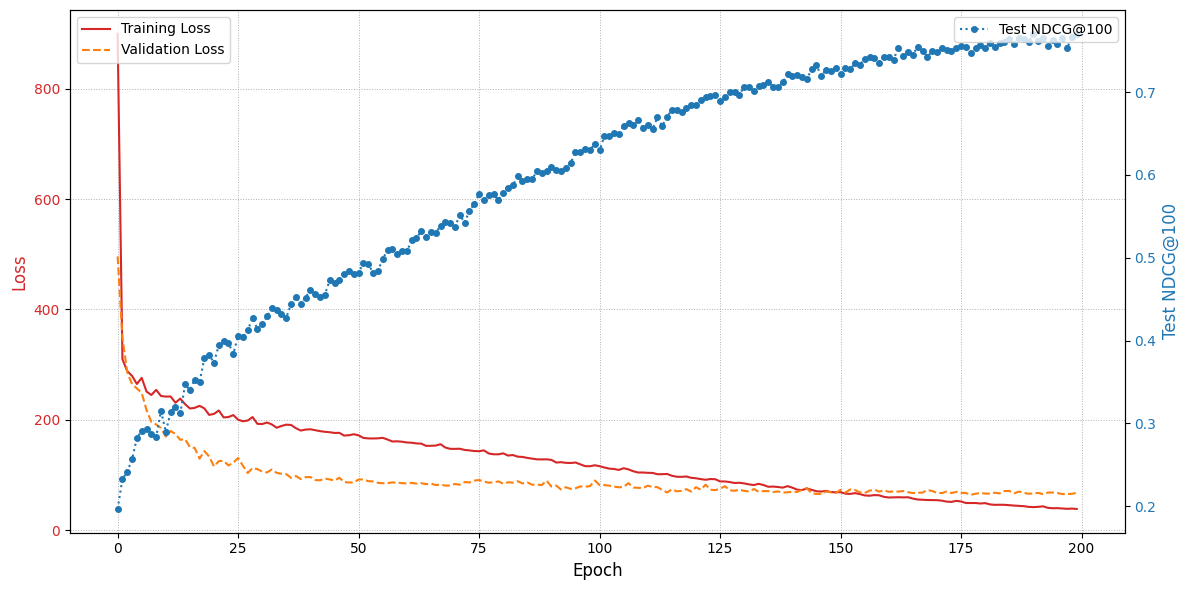

In [ ]:
# =============================================================================
# 5. VISUALISASI HASIL TRAINING FINAL
# =============================================================================
print("\n" + "="*50); print("--- TAHAP 5: VISUALISASI HASIL TRAINING ---"); print("="*50)
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:red'
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', color=color, fontsize=12)
ax1.plot(final_history.history['loss'], color=color, linestyle='-', label='Training Loss')
if 'val_loss' in final_history.history:
    ax1.plot(final_history.history['val_loss'], color='tab:orange', linestyle='--', label='Validation Loss')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')
ax1.grid(True, which='both', linestyle=':', linewidth=0.7)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel(f'Test NDCG@{K_EVAL}', color=color, fontsize=12)
ax2.plot(final_history.history[f'val_ndcg@{K_EVAL}'], color=color, marker='o', markersize=4, linestyle=':', label=f'Test NDCG@{K_EVAL}')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

fig.tight_layout()
plt.savefig(os.path.join(output_dir, 'training_curve.png'))
plt.show()


In [ ]:
# =============================================================================
# 6. EVALUASI FINAL DAN PEMBUATAN REKOMENDASI
# =============================================================================
print("\n" + "="*50); print("--- TAHAP 6: EVALUASI & REKOMENDASI ---"); print("="*50)
recon_test_matrix = final_model.predict(test_matrix.toarray(), batch_size=best_params['batch_size'])
train_val_mask = final_train_matrix.toarray().astype(bool)
recon_test_matrix[train_val_mask] = -np.inf

evaluation_metrics = []
for k in [5, 10, 20, 50]:
    precision, recall = precision_recall_at_k(recon_test_matrix, test_matrix, k)
    ndcg = ndcg_at_k(recon_test_matrix, test_matrix, k)
    evaluation_metrics.append({'K': k, 'Precision': precision, 'Recall': recall, 'NDCG': ndcg})

eval_df = pd.DataFrame(evaluation_metrics)
print("Hasil Evaluasi Final pada Test Set:")
print(eval_df.to_string(index=False))
eval_df.to_csv(os.path.join(output_dir, 'evaluation_metrics.csv'), index=False)

# Membuat rekomendasi Top-10
print("\nMembuat rekomendasi Top-10 untuk semua pengguna...")
full_matrix = final_train_matrix + test_matrix
full_predictions = final_model.predict(full_matrix.toarray(), batch_size=best_params['batch_size'])

# Buat peta invers untuk kembali ke ID asli
inv_user_map = {v: k for k, v in user_map.items()}
inv_item_map = {v: k for k, v in item_map.items()}

# Siapkan movie titles
movies_df.set_index('item_id', inplace=True)

recommendations = []
for user_idx in range(n_users):
    original_user_id = inv_user_map[user_idx] + 1 # Kembali ke ID asli 1-based

    # Ambil item yang belum ditonton pengguna
    uninteracted_items_mask = full_matrix[user_idx].toarray().flatten() == 0
    scores = full_predictions[user_idx, uninteracted_items_mask]
    item_indices = np.where(uninteracted_items_mask)[0]

    top_10_local_indices = np.argsort(-scores)[:10]
    top_10_item_indices = item_indices[top_10_local_indices]

    for item_idx in top_10_item_indices:
        original_item_id = inv_item_map[item_idx] + 1 # Kembali ke ID asli 1-based
        try:
            title = movies_df.loc[original_item_id, 'title']
        except KeyError:
            title = "N/A" # Jika item tidak ada di file u.item

        recommendations.append({
            'user_id': original_user_id,
            'item_id': original_item_id,
            'title': title,
            'score': full_predictions[user_idx, item_idx]
        })

reco_df = pd.DataFrame(recommendations)
reco_df.to_csv(os.path.join(output_dir, 'top_10_recommendations.csv'), index=False)
print("Rekomendasi Top-10 telah disimpan.")

# Tampilkan contoh rekomendasi untuk 5 pengguna pertama
print("\nContoh Rekomendasi:")
print(reco_df[reco_df.user_id.isin(list(range(1, 6)))].to_string())



--- TAHAP 6: EVALUASI & REKOMENDASI ---
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Hasil Evaluasi Final pada Test Set:
 K  Precision   Recall     NDCG
 5   0.747402 0.436730 0.828659
10   0.544539 0.553052 0.773893
20   0.374390 0.662801 0.754355
50   0.204517 0.787601 0.769270

Membuat rekomendasi Top-10 untuk semua pengguna...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Rekomendasi Top-10 telah disimpan.

Contoh Rekomendasi:
    user_id  item_id                                                       title     score
0         1      357                      One Flew Over the Cuckoo's Nest (1975)  0.867604
1         1      423                           E.T. the Extra-Terrestrial (1982)  0.763269
2         1      405                                  Mission: Impossible (1996)  0.761595
3         1      294                                            Liar Liar (1997)  0.703397
4         1      527                                               Gandhi (1982)  0.694767
5         1      568             

In [ ]:
# =============================================================================
# TAHAP 7: MEMBUAT MATRIKS OUTPUT DAN MENGHITUNG SPARSITY
# =============================================================================

# Definisikan fungsi untuk menghitung sparsity
def calculate_sparsity(matrix):
    """Menghitung sparsity dari sebuah matriks."""
    if hasattr(matrix, 'toarray'): # Cek jika ini sparse matrix
        matrix = matrix.toarray()

    num_interactions = np.count_nonzero(matrix)
    total_elements = matrix.size
    sparsity = 1.0 - (num_interactions / total_elements)
    return sparsity

print("\n" + "="*50)
print("--- TAHAP 7: MEMBUAT MATRIKS OUTPUT & MENGHITUNG SPARSITY ---")
print("="*50)

# --- 1. Matriks Interaksi Asli ---
print("\n--- 1. Memproses Matriks Interaksi Asli ---")
original_interaction_matrix = full_matrix.toarray()
# Gunakan ID yang sudah di-remap (0-based) untuk konsistensi
df_original = pd.DataFrame(original_interaction_matrix, index=range(n_users), columns=range(n_items))
df_original.to_csv(os.path.join(output_dir, '1_original_interaction_matrix.csv'))

# Hitung dan tampilkan sparsity
original_sparsity = calculate_sparsity(original_interaction_matrix)
n_original = np.count_nonzero(original_interaction_matrix)
print(f"✅ Matriks interaksi asli disimpan (Total Interaksi: {n_original}, Sparsity: {original_sparsity:.4f})")

# --- 2. Matriks Hasil Rekonstruksi (Full) ---
print("\n--- 2. Memproses Matriks Hasil Rekonstruksi VAE ---")
# full_predictions sudah dihitung di tahap sebelumnya
reconstructed_full_matrix = full_predictions
df_reconstructed = pd.DataFrame(reconstructed_full_matrix, index=range(n_users), columns=range(n_items))
df_reconstructed.to_csv(os.path.join(output_dir, '2_reconstructed_full_matrix.csv'))
print("✅ Matriks hasil rekonstruksi (skor probabilitas) disimpan.")
print("   (Catatan: Sparsity tidak dihitung untuk matriks skor karena matriks ini padat/dense).")

# --- 3. Membuat Beberapa Versi Matriks Interaksi yang Difilter ---
print("\n" + "="*50)
print("--- TAHAP 3: MEMBUAT BEBERAPA VERSI MATRIKS AUGMENTASI ---")
print("="*50)

# Tentukan daftar target total interaksi (N) yang diinginkan
# Sesuaikan dengan jumlah interaksi asli di MovieLens 100k
total_possible_interactions = n_users * n_items
# Target augmentasi sebagai persentase dari interaksi asli
augmentation_targets = [1.1, 1.2, 1.3, 1.4, 1.5] # Tambah 10%, 20%, dst.
list_of_N_targets = [int(n_original * aug) for aug in augmentation_targets]


# Lakukan loop untuk setiap target N
for i, N_TARGET in enumerate(list_of_N_targets):
    print(f"\n--- Memproses untuk Target N = {N_TARGET} ---")

    # Hitung jumlah interaksi yang perlu ditambahkan
    n_to_add = N_TARGET - n_original

    if n_to_add > 0:
        # Buat salinan skor rekonstruksi untuk mencari kandidat baru
        candidate_scores = np.copy(reconstructed_full_matrix)

        # Masking: atur skor interaksi asli menjadi -1 agar tidak terpilih lagi
        candidate_scores[original_interaction_matrix == 1] = -1.0

        # Cari skor threshold untuk N interaksi baru teratas secara global
        flat_candidate_scores = candidate_scores.flatten()
        # Gunakan partisi untuk efisiensi
        threshold = np.partition(flat_candidate_scores, -n_to_add)[-n_to_add]
        print(f"   Threshold skor untuk interaksi baru: {threshold:.4f}")

        # Buat matriks final, mulai dengan interaksi asli
        filtered_matrix = np.copy(original_interaction_matrix)

        # Tambahkan interaksi baru yang skornya di atas threshold
        new_interactions_mask = (reconstructed_full_matrix >= threshold) & (original_interaction_matrix == 0)
        filtered_matrix[new_interactions_mask] = 1

    else:
        # Jika N_TARGET lebih kecil dari interaksi asli, tidak ada yang ditambahkan
        print(f"   Target N ({N_TARGET}) lebih kecil dari data asli, tidak ada augmentasi yang dilakukan.")
        filtered_matrix = np.copy(original_interaction_matrix)

    # Buat nama file yang unik untuk setiap matriks
    file_name = f'3_{i+1}_filtered_augmented_matrix_N{N_TARGET}.csv'
    df_filtered = pd.DataFrame(filtered_matrix, index=range(n_users), columns=range(n_items))
    df_filtered.to_csv(os.path.join(output_dir, file_name))

    # Hitung dan tampilkan sparsity matriks final
    filtered_sparsity = calculate_sparsity(filtered_matrix)
    final_interactions = np.count_nonzero(filtered_matrix)
    print(f"✅ Matriks terfilter untuk N={N_TARGET} disimpan sebagai '{file_name}'")
    print(f"   (Total Interaksi: {final_interactions}, Sparsity: {filtered_sparsity:.4f})")

print("\n" + "="*50)
print("Semua proses telah selesai. Periksa file di direktori:", output_dir)
print("="*50)


--- TAHAP 7: MEMBUAT MATRIKS OUTPUT & MENGHITUNG SPARSITY ---

--- 1. Memproses Matriks Interaksi Asli ---
✅ Matriks interaksi asli disimpan (Total Interaksi: 100000, Sparsity: 0.9370)

--- 2. Memproses Matriks Hasil Rekonstruksi VAE ---
✅ Matriks hasil rekonstruksi (skor probabilitas) disimpan.
   (Catatan: Sparsity tidak dihitung untuk matriks skor karena matriks ini padat/dense).

--- TAHAP 3: MEMBUAT BEBERAPA VERSI MATRIKS AUGMENTASI ---

--- Memproses untuk Target N = 110000 ---
   Threshold skor untuk interaksi baru: 0.2521
✅ Matriks terfilter untuk N=110000 disimpan sebagai '3_1_filtered_augmented_matrix_N110000.csv'
   (Total Interaksi: 110000, Sparsity: 0.9306)

--- Memproses untuk Target N = 120000 ---
   Threshold skor untuk interaksi baru: 0.1665
✅ Matriks terfilter untuk N=120000 disimpan sebagai '3_2_filtered_augmented_matrix_N120000.csv'
   (Total Interaksi: 120000, Sparsity: 0.9243)

--- Memproses untuk Target N = 130000 ---
   Threshold skor untuk interaksi baru: 0.12